# Identification of plant leaf diseases using CNN

Source: https://www.kaggle.com/code/kunjushaji/identification-of-plant-leaf-diseases-using-cnn

Another Great Resources for using Keras starting with a Dataset: https://keras.io/examples/vision/image_classification_from_scratch/

**About Dataset**

This dataset is recreated using offline augmentation from the original dataset. The original dataset can be found on this [here](https://github.com/spMohanty/PlantVillage-Dataset). This dataset consists of about 87K rgb images of healthy and diseased crop leaves which is categorized into 38 different classes. The total dataset is divided into 80/20 ratio of training and validation set preserving the directory structure. A new directory containing 33 test images is created later for prediction purpose.

**Importing necessary python libraries and Modules**
**Import kaggle so we can use the dataset after creating an account API token**
More about Opendatasets: https://pypi.org/project/opendatasets/



In [2]:
!pip install plotly

# installing Kaggle on the machine:
#!pip install kaggle

# Just use OpenDatasets instead of kaggle's pre-built one -1 is quiet install flag for pip
!pip install -q opendatasets



**Upload the API Toke generated from Kaggle from your local PC**
You will have to find the file location and upload it

**NOTE:** You could also just use:

```
from google.colab import drive
drive.mount('/content/gdrive')
```

Can Also write directly to google Colab using:

```
!touch "/content/gdrive/My Drive/sample_file.txt"
```

*Source:* https://neptune.ai/blog/google-colab-dealing-with-files



In [4]:
from google.colab import files # import files from colab

In [ ]:
 # upload kaggle.json file from pc
files.upload()

Note: True/False Positive Rate (TPR,FPR) and AUC (Area Under The Curve) ROC (Receiver Operating Characteristics) important performance characteristics

Higher AUC means better chances of discrimintating TPR/FPR and 50% means just a guess essentially

Source: https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.layers  import Concatenate
from tensorflow.keras.layers import AveragePooling2D, Dropout, Input, BatchNormalization
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Input, Add, Dense,GlobalAvgPool2D, Concatenate, AvgPool2D, Dropout, ReLU, Activation, MaxPool2D, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
import matplotlib.pyplot as plt # for ploting graph
import os
#-------------------------------------------------------------------------------
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
# scikit-learn confusion matrix command
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
#For ROC
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from time import perf_counter
#-------------------------------------------------------------------------------
import plotly.graph_objects as go_obj
from plotly.subplots import make_subplots
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#-------------------------------------------------------------------------------


**Easier Method:** Use opendatasets to download the kaggle library instead of creating a folder and using kaggle commands

Dataset being used: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset

Total 87K rgb images from PlantVillage with different orientations applied

In [4]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset')

100%|██████████| 2.70G/2.70G [00:29<00:00, 98.2MB/s]


Split into Training and Validation Dataset

In [5]:
#copied from google colab
#/content/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train
dataset_root = "/content/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/"
train_path = os.path.join(dataset_root, "New Plant Diseases Dataset(Augmented)/train")
valid_path = os.path.join(dataset_root, "New Plant Diseases Dataset(Augmented)/valid")
test_path = "/content/new-plant-diseases-dataset/test/test"
diseases   = os.listdir(train_path) # name of the disease here
batch_size=25 # batch size

# Preprocessing for input images for rotation, shifts, and other image distortion (ImageDataGenerator)#

Source: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [6]:
#Setting the Traning dataset folder
training_set = ImageDataGenerator( rescale = 1/255.5)
training_data = training_set.flow_from_directory(
    train_path,
    target_size = (224,224),
    class_mode = "categorical",
    batch_size = batch_size
  )

Found 70295 images belonging to 38 classes.


In [7]:
#Setting the validation dataset folder
validation_set = ImageDataGenerator( rescale = 1/255.5)
validation_data = validation_set.flow_from_directory(
    valid_path,
    target_size = (224,224),
    class_mode = "categorical",
    shuffle = False,  # For corretly printing the ConfusionMartix and Roc curvs
    batch_size = batch_size
)

Found 17572 images belonging to 38 classes.


**Data exploration**

Plotting 16 different classes

In [14]:
#Finding the categories
categories = training_data.class_indices.keys()
print(categories)

dict_keys(['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato__

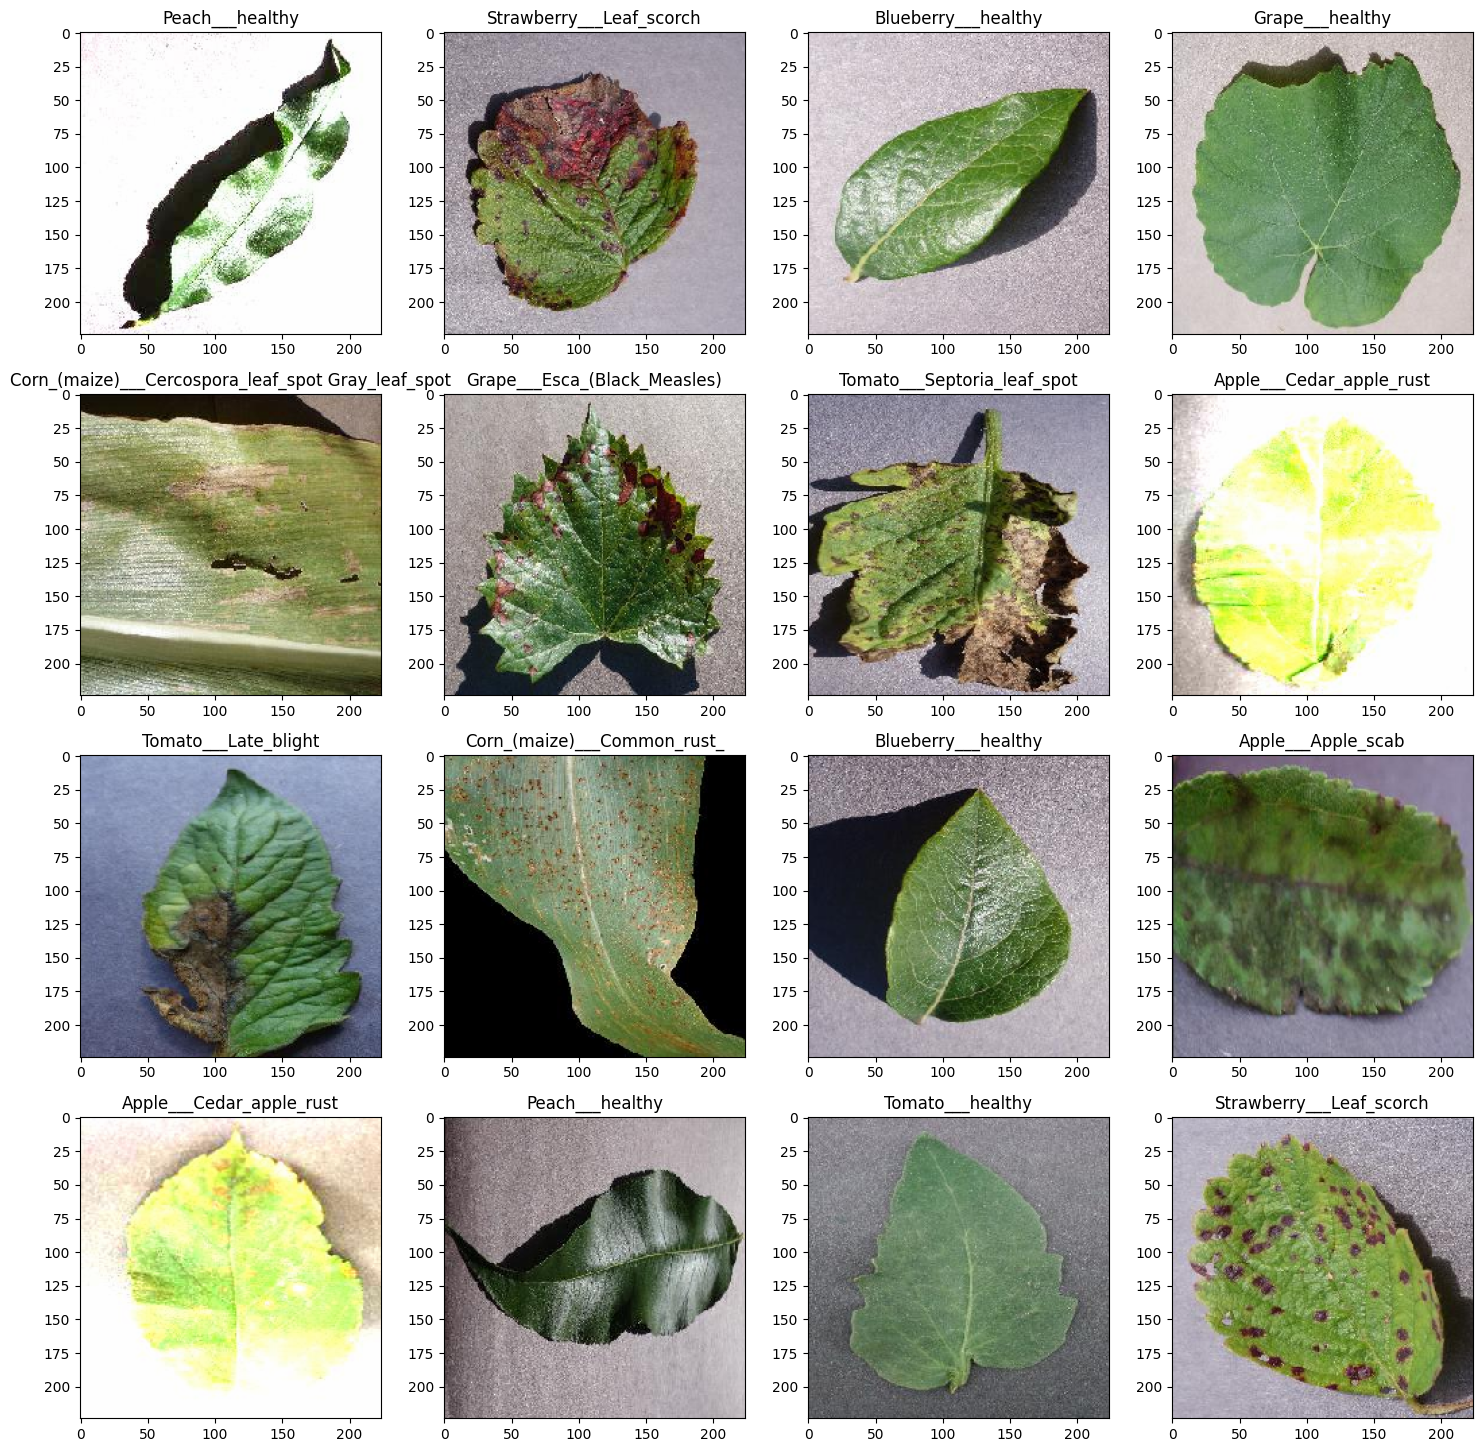

In [15]:
#getting the class name and displaying 16 images and its class name
classes=list(training_data.class_indices.keys())
# 18" x 18" total figure size
plt.figure(figsize=(18,18))
for X_batch, y_batch in training_data:

    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
    # show the plot
    plt.show()
   # plt.savefig('rnd.jpg', bbox_inches = 'tight')
    break

In [16]:
#Finding Number of Uniqe plants in the dataset
plants = []
NumberOfDiseases = 0
disease_names = []

# remove _ and , from names of plants
#.replace(char_remove,remove_value) only for 1
# use .maketrans and translate() for multiple
# have to use .replace() for characters with more
# than 1 value like ___ dict doesn't work in translate
map_table = str.maketrans({'_':'',',':''})

# if plant contains , or _ replace with nothing
for i,plant in enumerate(diseases):
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1
        disease_names.append(diseases[i].replace('___',''))
# need len to iterate using range (0,len(disease_names))
for i in range(len(disease_names)):
    disease_names[i] = disease_names[i].translate(map_table)

# if left as basic list / not np array then will not have nice line break
# allowing to fit within text box in jupyter notebook
disease_names = np.array(disease_names)


# pre-allocate array with "filler" then add names without artifacts for display
# Also display the name of each disease (LOOKS LIKE A FEW HEALTHY ARE IN THERE)
plant_names = np.full(len(plants), "filler", dtype=object)
for i in range(len(plants)):
  plant_names[i] = plants[i].translate(map_table)

# display unique plants and number
print(f"Unique Plants are: \n{plant_names}\n")
print("Number of Unique Plants are: {}".format(len(plants)),"\n")

# displayig number of unique diseases
print(f"Unique Diseases are \n{disease_names}\n")
print("Number of diseases are: {}".format(NumberOfDiseases))
#print(diseases)

Unique Plants are: 
['Apple' 'Tomato' 'Peach' 'Corn(maize)' 'Potato' 'Strawberry' 'Grape'
 'Blueberry' 'Cherry(includingsour)' 'Pepperbell' 'Soybean' 'Squash'
 'Orange' 'Raspberry']

Number of Unique Plants are: 14 

Unique Diseases are 
['AppleBlackrot' 'TomatoSpidermites Two-spottedspidermite'
 'PeachBacterialspot' 'TomatoTomatomosaicvirus' 'TomatoEarlyblight'
 'Corn(maize)Commonrust' 'PotatoEarlyblight' 'TomatoTargetSpot'
 'TomatoSeptorialeafspot' 'TomatoLateblight' 'TomatoBacterialspot'
 'GrapeBlackrot' 'SquashPowderymildew'
 'OrangeHaunglongbing(Citrusgreening)'
 'GrapeLeafblight(IsariopsisLeafSpot)' 'TomatoTomatoYellowLeafCurlVirus'
 'AppleCedarapplerust' 'AppleApplescab' 'StrawberryLeafscorch'
 'GrapeEsca(BlackMeasles)' 'PotatoLateblight' 'TomatoLeafMold'
 'PepperbellBacterialspot' 'Corn(maize)Cercosporaleafspot Grayleafspot'
 'Cherry(includingsour)Powderymildew' 'Corn(maize)NorthernLeafBlight']

Number of diseases are: 26


In [17]:
# Number of images for each disease
nums_train = {}
nums_val = {}
for disease in diseases:
    nums_train[disease] = len(os.listdir(train_path + '/' + disease))
    nums_val[disease] = len(os.listdir(valid_path + '/' + disease))
img_per_class_train = pd.DataFrame(nums_train.values(), index=nums_train.keys(), columns=["no. of images"])
print('Train datast distribution :')
img_per_class_train


Train datast distribution :


no. of images
Apple___Black_rot                                            1987
Tomato___Spider_mites Two-spotted_spider_mite                1741
Peach___Bacterial_spot                                       1838
Tomato___Tomato_mosaic_virus                                 1790
Tomato___Early_blight                                        1920
Peach___healthy                                              1728
Corn_(maize)___Common_rust_                                  1907
Potato___Early_blight                                        1939
Strawberry___healthy                                         1824
Apple___healthy                                              2008
Tomato___Target_Spot                                         1827
Tomato___Septoria_leaf_spot                                  1745
Potato___healthy                                             1824
Grape___healthy                                              1692
Tomato___Late_blight                                         1851
Blueberry___healthy                                          1816
Cherry_(including_sour)___healthy                            1826
Tomato___Bacterial_spot                                      1702
Grape___Black_rot                                            1888
Pepper,_bell___healthy                                       1988
Soybean___healthy                                            2022
Squash___Powdery_mildew                                      1736
Orange___Haunglongbing_(Citrus_greening)                     2010
Corn_(maize)___healthy                                       1859
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)                   1722
Tomato___Tomato_Yellow_Leaf_Curl_Virus                       1961
Apple___Cedar_apple_rust                                     1760
Apple___Apple_scab                                           2016
Strawberry___Leaf_scorch                                     1774
Grape___Esca_(Black_Measles)                                 1920
Potato___Late_blight                                         1939
Tomato___healthy                                             1926
Tomato___Leaf_Mold                                           1882
Pepper,_bell___Bacterial_spot                                1913
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot           1642
Cherry_(including_sour)___Powdery_mildew                     1683
Corn_(maize)___Northern_Leaf_Blight                          1908
Raspberry___healthy                                          1781

Text(0.5, 1.0, 'Images per each class of plant disease')

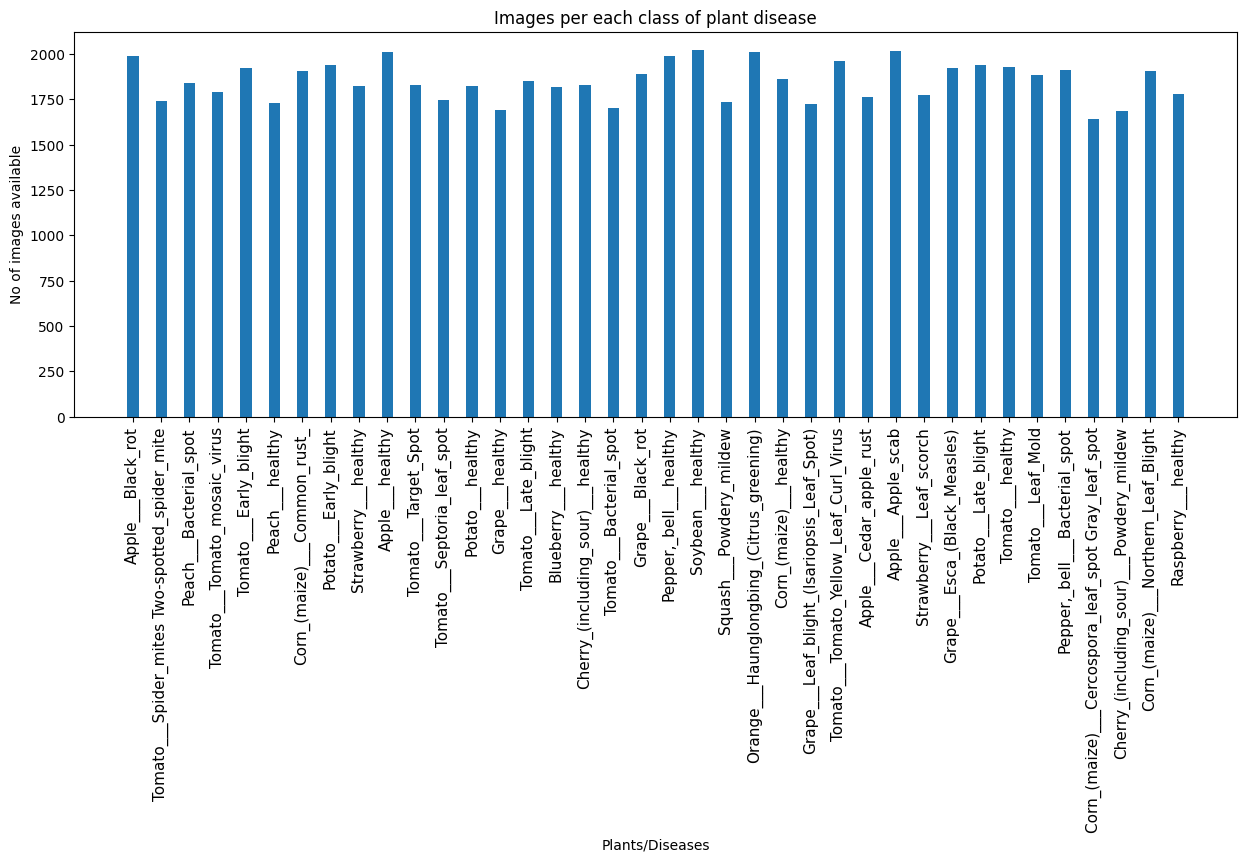

In [18]:
# section for visualising each class in the training raw dataset
train_diratory=train_path
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_path + '/' + disease))

# plotting number of images available for each image classes
index = [n for n in range(38)]
plt.figure(figsize=(15, 5))
plt.bar(index, [n for n in nums.values()], width=0.4)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=11, rotation=90)
plt.title('Images per each class of plant disease')


# Use the below code to load  in a model instead of creating and training one #

In [6]:
# Install necessary Package:
!pip install h5py
from tensorflow.keras.models import load_model

In [20]:
# Upload trained Network Model
files.upload()

Saving model_12epochs50batchsize.h5 to model_12epochs50batchsize.h5


In [24]:
# Source for Loading Models: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
# upload save model to load
model = load_model('/content/model_12epochs50batchsize.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_1 (Bat  (None, 54, 54, 64)        256       
 chNormalization)                                                
                                                      

In [7]:
#Custom Model here
def define_custom_model():
  custom_model = keras.Sequential()
  custom_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
  custom_model.add(layers.MaxPooling2D((2, 2)))
  custom_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  custom_model.add(layers.MaxPooling2D((2, 2)))

  custom_model.add(BatchNormalization()) # Adding  Batch normalizitoan #

  custom_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  custom_model.add(layers.MaxPooling2D((2, 2)))
  custom_model.add(layers.Conv2D(256, (3, 3), activation='relu'))
  custom_model.add(layers.MaxPooling2D((2, 2)))
  custom_model.add(layers.Conv2D(256, (3, 3), activation='relu'))
  custom_model.add(layers.MaxPooling2D((2, 2)))
  custom_model.add(layers.Conv2D(512, (3, 3), activation='relu'))
  custom_model.add(layers.MaxPooling2D((3, 3)))

  custom_model.add(layers.Flatten())
  custom_model.add(layers.Dropout(0.5))
  custom_model.add(Flatten()) # doesn't provide any benefit at all
  custom_model.add(Dense(1024,activation='relu'))
  custom_model.add(layers.Dense((38), activation='softmax'))

  return custom_model
################################################################################

In [ ]:
###############################################################################
#Setting up differt custome  models  here
model = define_custom_model()  # setting the model -5
################################################################################

In [ ]:
################################################################################
#Model compiling
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
################################################################################

In [ ]:
model.summary()

# Visualizing Convolutional Filters of the Loaded Network using tf-keras-vis library #

*  Goal to see activation maps using GradCAM (Gradient Class Activation Maps) for 1 or 2 images (heatmap of specific layer's found features)
* Visualize Convolution Layer outputs



In [8]:
# install visualization package for CNN filters
#!pip install git+git://github.com/raghakot/keras-vis.git --upgrade --no-deps
!pip install tf-keras-vis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 295.7 kB/s eta 0:00:00


(3, 3, 3, 32)


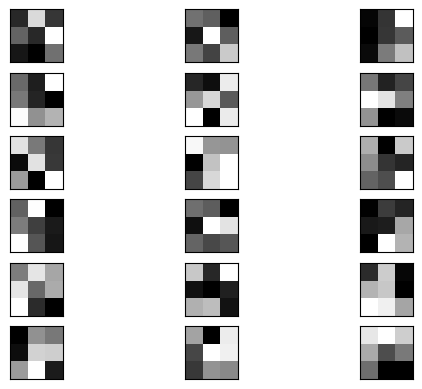

In [20]:
#Visualize the loaded convolutional Filters
# First Visualize Filter then view application to images
# Source: https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

# retrieve weights from the first hidden layer
filters, biases = model.layers[0].get_weights()
# normalize filter values to 0-1 so we can visualize them
print(np.shape(filters))
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()

# Visualizing Convolutional Filters with tf-keras-vis #
Source: https://keisen.github.io/tf-keras-vis-docs/examples/visualize_conv_filters.html

We choose a layer (2d_11 last layer of network) and the desired filers to view. Using the ExtractIntermediateLayer() and ReplaceToLinear methods we can obtain outputs. Then we can use the ActivationMaximization() method on the CategoricalScore for the selected filers in the desired layer of the network to maximize the value computed by the score function.

- Ensure the seed_input is the correct size of the filers being visualized for an overlay on the image. Three random images with size of input and 3 color channels with random pixel values 0-255 with tf.random.uniform.
--> These seeds are inputs/starting points for visualization process where pixels are iteratively adjusted to maximize activation of specific neurons / filters in the networks

* GradCAM: Understand parts of image that contribute to prediction of specific class
* Activation Maximization: Generate images that strongly activate specific neurons / filters giving insight to learned features
* GradCAM - visualize decision making process / Activation Maximization gain instights on learned features of filters

In [10]:
# imports from tf-keras-vis
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.utils.scores import CategoricalScore
# extract intermediate layer and have output at linear
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear

ModuleNotFoundError: ignored

In [45]:
# layer name      size    # tunable parameters
#  conv2d_11 (Conv2D)          (None, 3, 3, 512)         1180160
layer_name = 'conv2d_11' # Last of 6 convolution layers in our network
extract_intermediate_layer = ExtractIntermediateLayer(index_or_name=layer_name)
replace2linear = ReplaceToLinear()


# select the filters within the layer you would like to view
# for this example we will view
filter_numbers = [63, 132, 320]
scores = CategoricalScore(filter_numbers)

# Define seed inputs whose shape is (samples, height, width, channels).
# ActivationMaximization will maximize the value computed by the score function.
activation_maximization = ActivationMaximization(model,
                                                 # Please note that `extract_intermediate_layer` has to come before `replace2linear`.
                                                 model_modifier=[extract_intermediate_layer, replace2linear],
                                                 clone=False)

seed_input = tf.random.uniform((3, 224, 224, 3), 0, 255)

# Generate maximized activation
activations = activation_maximization(scores,
                                      seed_input=seed_input,
                                      callbacks=[Progress()])

200/200 [==============================] - 16s 79ms/step - Score: 9558.0283 - TotalVariation2D: 12.2182 - Norm: 38.1892


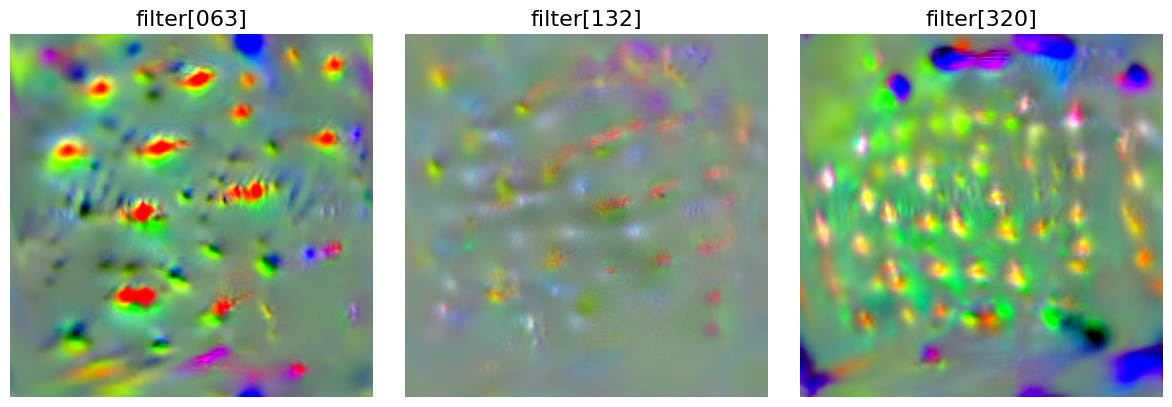

In [50]:
# Normalize activations
# handles cases where minimum activation is not zero
normalized_activations = [(act - np.min(act)) / (np.max(act) - np.min(act)) for act in activations]

## Since v0.6.0, calling `astype()` is NOT necessary.
# activations = activations[0].astype(np.uint8)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, filter_number in enumerate(filter_numbers):
    ax[i].set_title('filter[{:03d}]'.format(filter_number), fontsize=16)
    ax[i].imshow(normalized_activations[i], cmap='viridis')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

# Visualizing Heatmaps of features from GradCAM #

In [30]:
# Source 2 for more complex visualizations: https://www.analyticsvidhya.com/blog/2018/03/essentials-of-deep-learning-visualizing-convolutional-neural-networks/
# 2 other future Resources:
# Maximal Activation Maps & Image Occlusion (Heatmap) to see important parts of image
# Gradient Based Methods: Saliency Maps & Class Activation Maps

# colormap
from matplotlib import cm
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
# Categorical Score is also imported above for visualizing the convolutional filters
from tf_keras_vis.utils.scores import CategoricalScore
#from tf_keras_vis.utils import rgb_to_grayscale
import cv2

In [33]:
# ensure correct casing --> could make either the targes and disease classes lower or upper also
#target_string1 = "blight"
#target_string2 = "grape"
target_string1 = "peach"
target_string2 = "bacterial"

#full_desired_string = Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
# np.where looks for exact match, char.find is better for this case
# != -1 creates a boolean array of the same shape as np.char.find(diseases, target_string),
#where each element is True if the corresponding element in the result of np.char.find
#is not equal to -1, and False otherwise.

# Convert both target strings and diseases array to lowercase
target_string1_lower = target_string1.lower()
target_string2_lower = target_string2.lower()
diseases_lower = np.char.lower(diseases)

# Find indices where both target strings are present (case-insensitive)
indices = np.where((np.char.find(diseases_lower, target_string1_lower) != -1) & (np.char.find(diseases_lower, target_string2_lower) != -1))[0]

print("Indices where '{}' and '{}' are present: {}".format(target_string1, target_string2, indices))
# Take the resulting indices and use in gradcam

# creating a dictionary of disease with indices:
# Create a dictionary to map disease labels to indices
label_to_index = {label: index for index, label in enumerate(diseases)}

# Create a matrix of indices
disease_matrix = np.array([label_to_index[label] for label in diseases])
#print(disease_matrix)
index_correct = indices[0]
#print(index_correct)

Indices where 'peach' and 'bacterial' are present: [2]


Peach___Bacterial_spot
0.0


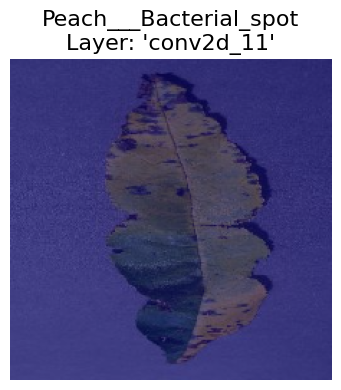

In [55]:
# Gradient based Class Activation Maps (GradCAM)

# Create GradCAM++ object
# replace output softmax to linear
# so can not have normalized values as typical output of softmax
#img_path = "/content/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Grape___Leaf_blight_(Isariopsis_Leaf_Spot)/02605da9-90bc-4456-ae3f-fa42d0b49c29___FAM_L.Blight 1504_flipLR.JPG"
img_path = "/content/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Peach___Bacterial_spot/00f87dfc-bf6c-481e-9022-bfb98224d4b7___Rutg._Bact.S 1965.JPG"

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
# convert to numpy array for the Gradcam
img_array = tf.keras.preprocessing.image.img_to_array(img)


# Choose the last convolutional layer in your model
#layer_name = 'conv2d_3'  # Change this to the appropriate layer in your model
layer_name = 'conv2d_11'  # Change this to the appropriate layer in your model

# Choose the class index for which you want to visualize the GradCAM
# all classes stored in diseases

# Create GradCAM object
gradcam = GradcamPlusPlus(model, model_modifier=ReplaceToLinear(), clone=False)

# In Example on: https://keisen.github.io/tf-keras-vis-docs/examples/attentions.html#GradCAM++
# X = preprocess_input(images)
# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle
# score = CategoricalScore([1, 294, 413])
# score = indices for my case = the correct class for the image

filter_numbers = [6, 7, 8]
# Generate GradCAM map
# ensure correct disease from index_correct
print(diseases[index_correct])
score = CategoricalScore(index_correct)
#score = CategoricalScore(filter_numbers)

cam = gradcam(score, img_array, penultimate_layer=layer_name)

# Overlay the heatmap on the original image
# Convert heatmap to grayscale manually
#print(np.shape(cam))
# cam = normalize(cam)
image_titles = diseases[index_correct]
#print(image_titles)
# Render
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
'''
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
'''
# adjusting for just 1
title = image_titles
images = img
print(np.max(cam))
#print(np.shape(heatmap))

heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
heatmap = heatmap[0,:,:,:]
full_title = title + f"\nLayer: '{layer_name}'"
ax.set_title(full_title, fontsize=16)
ax.imshow(images)
ax.imshow(heatmap, cmap='coolwarm', alpha=0.55)
ax.axis('off')
# show original image
plt.tight_layout()
plt.show()

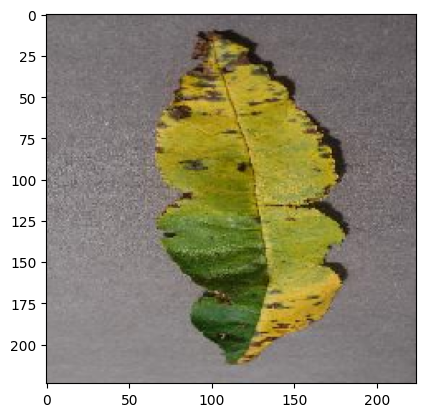

In [39]:
imgplot = plt.imshow(images)

In [145]:
import keras.callbacks as callbacks
import time
early_stopping_cb = callbacks.EarlyStopping(monitor="loss", patience=3)
print(training_data)

In [146]:
start_training = perf_counter()
history = model.fit(
    training_data,
    validation_data = validation_data,
    epochs = 12, batch_size = 50,
    callbacks=[early_stopping_cb]
)
end_training= perf_counter()

Epoch 1/12
2812/2812 [==============================] - 179s 62ms/step - loss: 1.3808 - accuracy: 0.5844 - val_loss: 0.5583 - val_accuracy: 0.8253
Epoch 2/12
2812/2812 [==============================] - 176s 63ms/step - loss: 0.4828 - accuracy: 0.8466 - val_loss: 0.2646 - val_accuracy: 0.9124
Epoch 3/12
2812/2812 [==============================] - 176s 63ms/step - loss: 0.3030 - accuracy: 0.9019 - val_loss: 0.2509 - val_accuracy: 0.9174
Epoch 4/12
2812/2812 [==============================] - 176s 62ms/step - loss: 0.2238 - accuracy: 0.9280 - val_loss: 0.1318 - val_accuracy: 0.9544
Epoch 5/12
2812/2812 [==============================] - 173s 62ms/step - loss: 0.1686 - accuracy: 0.9445 - val_loss: 0.1026 - val_accuracy: 0.9651
Epoch 6/12
2812/2812 [==============================] - 175s 62ms/step - loss: 0.1330 - accuracy: 0.9552 - val_loss: 0.1131 - val_accuracy: 0.9620
Epoch 7/12
2812/2812 [==============================] - 173s 62ms/step - loss: 0.1114 - accuracy: 0.9631 - val_loss: 0

In [9]:
def Display_Model_Loss_Accuracy(history):
  # funtion for ploting model accuracy and loss graph
  #=============================================================================
  # Create figure with secondary y-axis
  fig = make_subplots(specs=[[{"secondary_y": True}]])

  # Adding traces ------------------------------------------------------------
  fig.add_trace(go_obj.Scatter( y=history.history['val_loss'], name="val_loss"),secondary_y=False,)
  fig.add_trace(go_obj.Scatter( y=history.history['loss'], name="loss"),secondary_y=False,)
  fig.add_trace(go_obj.Scatter( y=history.history['val_accuracy'], name="val accuracy"),secondary_y=True,)
  fig.add_trace(go_obj.Scatter( y=history.history['accuracy'], name="accuracy"),secondary_y=True,)

  # Adding figure title---------------------------------------------------------
  fig.update_layout(title_text="Loss/Accuracy of Final Model")
  # Set x-axis title
  fig.update_xaxes(title_text="Epoch")

  # Set y-axes titles-----------------------------------------------------------
  fig.update_yaxes(title_text="<b>primary</b> Loss", secondary_y=False)
  fig.update_yaxes(title_text="<b>secondary</b> Accuracy", secondary_y=True)
  fig.show()
  #============================================================================

In [149]:
Display_Model_Loss_Accuracy(history) # calling funciton to print model accuracy graph

In [10]:
################################################################################
def validate_test_images_and_display(model,number_test_images):
  #funtion for prediting the 33 supplied test image's file name and predicted class
  test_image_data = []
  test_image_filenames = []
  IMG_SHAPE  = (224, 224)
  #-----------------------------------------------------------------------------
  for img_name in os.listdir(test_path):
    img = load_img(os.path.join(test_path, img_name), target_size = IMG_SHAPE)
    test_image_data.append(img_to_array(img, dtype = 'uint8'))
    test_image_filenames.append(img_name)

  test_image_data = np.array(test_image_data)/255
  #print(f'\nTotal testing images: {len(test_image_data)}')
  #-----------------------------------------------------------------------------
  test_pred = np.argmax(model.predict(test_image_data), axis = 1)

  class_name_lookup = {name: index for index, name in training_data.class_indices.items()}
  #for k, v in class_name_lookup.items():
  #  print(f"{k:2} : {v}")

  test_pred_classes = [class_name_lookup[i] for i in test_pred]

  data_frame=pd.DataFrame({
    "Filename": test_image_filenames,
    "Predicted classes": test_pred_classes
    })
  display (data_frame) # Displaying the dataframe
  #-----------------------------------------------------------------------------
  #Display test images and its real label and predecited label here
  plt.subplots(nrows = 3, ncols = 4, figsize = (20, 15))

  for i in range(number_test_images):
    plt.subplot(3, 4, i + 1)
    plt.axis(False)
    plt.grid(False)
    plt.imshow(test_image_data[i])
    plt.title(f"True: {test_image_filenames[i][:-4]}\nPrediction:{test_pred_classes[i]}")
  plt.show()
  #-----------------------------------------------------------------------------
################################################################################

2/2 [==============================] - 1s 132ms/step


Filename                       Predicted classes
0       PotatoEarlyBlight5.JPG                   Potato___Early_blight
1       PotatoEarlyBlight1.JPG                   Potato___Early_blight
2               AppleScab1.JPG                Apple___Cedar_apple_rust
3       TomatoEarlyBlight1.JPG                   Tomato___Early_blight
4       TomatoEarlyBlight4.JPG                   Tomato___Early_blight
5           TomatoHealthy1.JPG                        Tomato___healthy
6       TomatoEarlyBlight6.JPG                   Tomato___Early_blight
7       PotatoEarlyBlight2.JPG                   Potato___Early_blight
8       TomatoEarlyBlight3.JPG                   Tomato___Early_blight
9       PotatoEarlyBlight4.JPG                   Potato___Early_blight
10         AppleCedarRust1.JPG                Apple___Cedar_apple_rust
11              AppleScab2.JPG                      Apple___Apple_scab
12  TomatoYellowCurlVirus5.JPG  Tomato___Tomato_Yellow_Leaf_Curl_Virus
13         AppleCedarRust3.JPG                Apple___Cedar_apple_rust
14          TomatoHealthy2.JPG                        Tomato___healthy
15  TomatoYellowCurlVirus4.JPG  Tomato___Tomato_Yellow_Leaf_Curl_Virus
16          TomatoHealthy4.JPG                        Tomato___healthy
17  TomatoYellowCurlVirus3.JPG  Tomato___Tomato_Yellow_Leaf_Curl_Virus
18          PotatoHealthy1.JPG                        Potato___healthy
19         CornCommonRust3.JPG             Corn_(maize)___Common_rust_
20  TomatoYellowCurlVirus2.JPG  Tomato___Tomato_Yellow_Leaf_Curl_Virus
21      TomatoEarlyBlight5.JPG                   Tomato___Early_blight
22              AppleScab3.JPG                   Potato___Early_blight
23         AppleCedarRust2.JPG                Apple___Cedar_apple_rust
24          TomatoHealthy3.JPG                        Tomato___healthy
25  TomatoYellowCurlVirus1.JPG  Tomato___Tomato_Yellow_Leaf_Curl_Virus
26         AppleCedarRust4.JPG                Apple___Cedar_apple_rust
27  TomatoYellowCurlVirus6.JPG  Tomato___Tomato_Yellow_Leaf_Curl_Virus
28      PotatoEarlyBlight3.JPG                   Potato___Early_blight
29      TomatoEarlyBlight2.JPG                   Tomato___Early_blight
30          PotatoHealthy2.JPG                        Potato___healthy
31         CornCommonRust1.JPG             Corn_(maize)___Common_rust_
32         CornCommonRust2.JPG             Corn_(maize)___Common_rust_

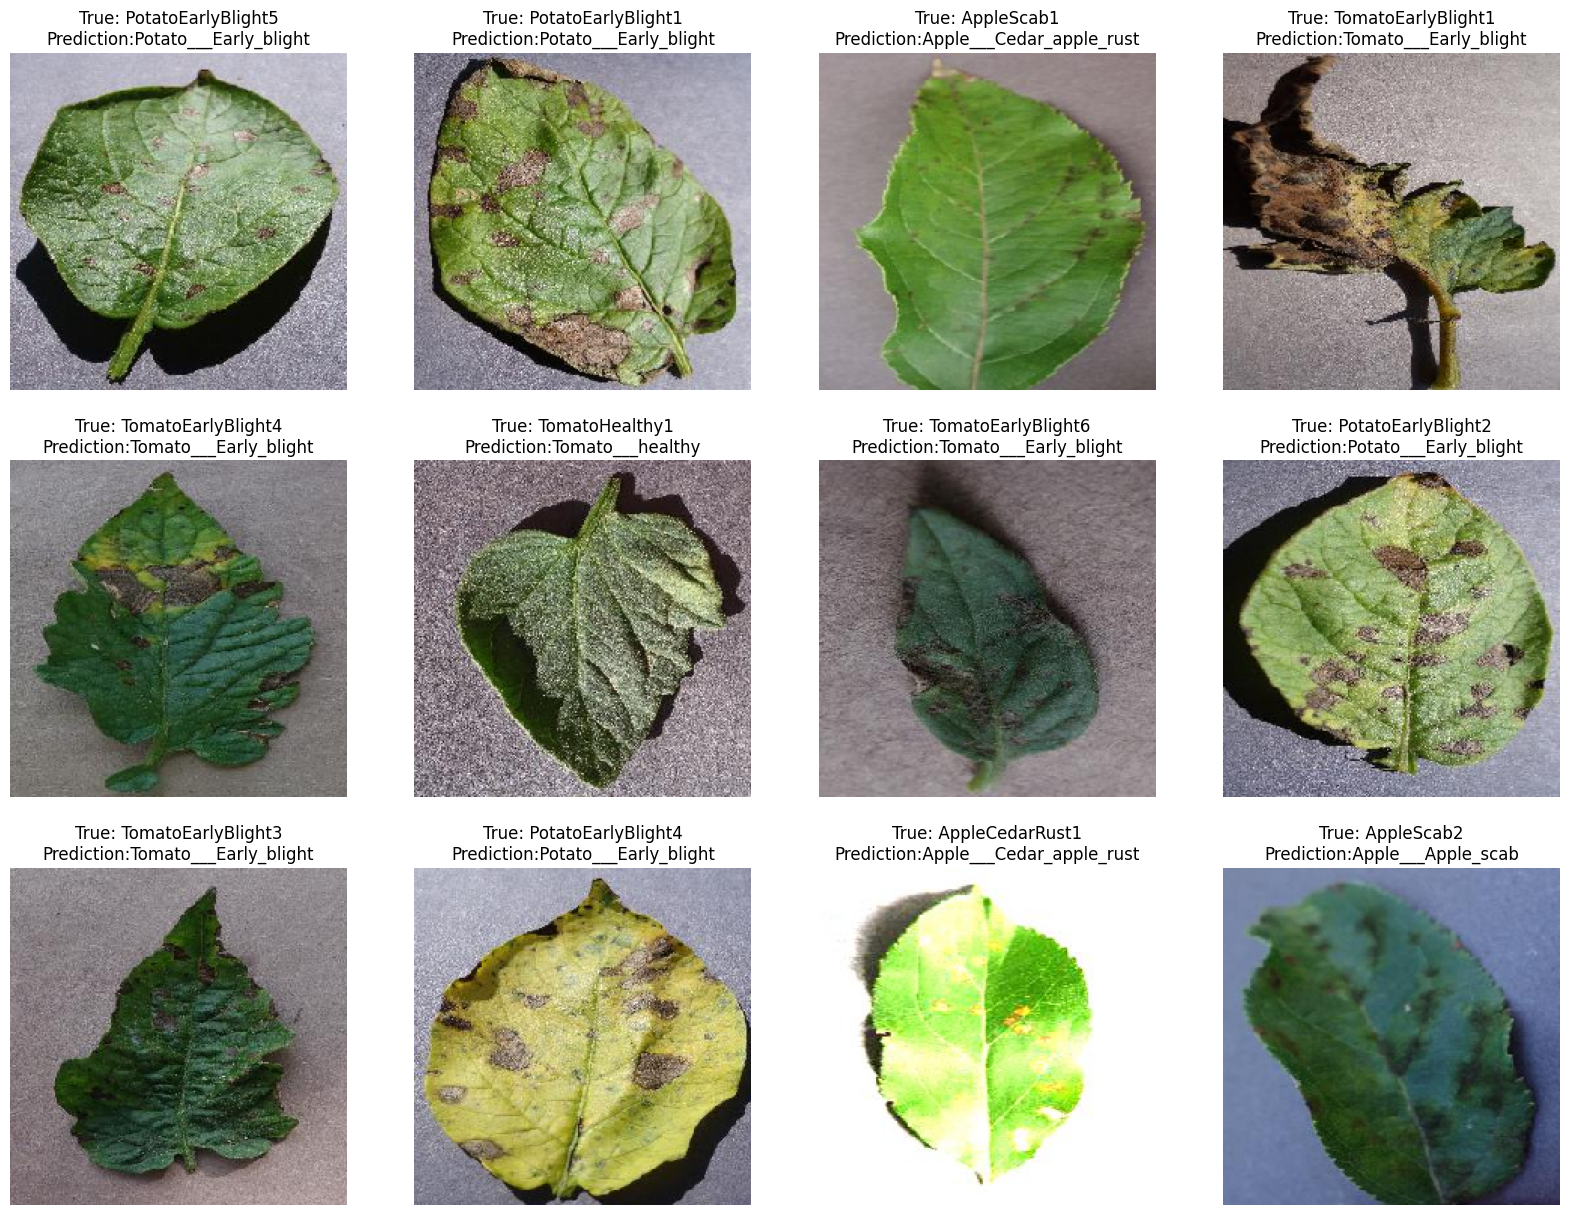

In [128]:
number_test_images=12 # printing 12 images from the supplied test images
# Predicting the supplied 33 images which is unkonwn to the model
validate_test_images_and_display(model,number_test_images)

In [129]:
#For confusion matrix
val_true = validation_data.classes
val_pred = np.argmax(model.predict(validation_data), axis = 1)
val_pred_float=model.predict(validation_data)
class_name_lookup = {name: index for index, name in training_data.class_indices.items()}

703/703 [==============================] - 32s 45ms/step


In [11]:
################################################################################
#Fuction to dispay confusion matrix based on the predections.
def Display_Confusion_Matrix(val_true,val_pred,class_name_lookup):
  # here printing the confustion matrix
  _, ax = plt.subplots(figsize = (20, 16))
  ax.grid(False)

  ConfusionMatrixDisplay(confusion_matrix(val_true, val_pred, labels = list(class_name_lookup.keys())),
                        display_labels = list(class_name_lookup.values())
                        ).plot(ax = ax, xticks_rotation = 'vertical')

  plt.savefig('confusion_matrix.jpg', bbox_inches = 'tight')
  plt.show()
################################################################################

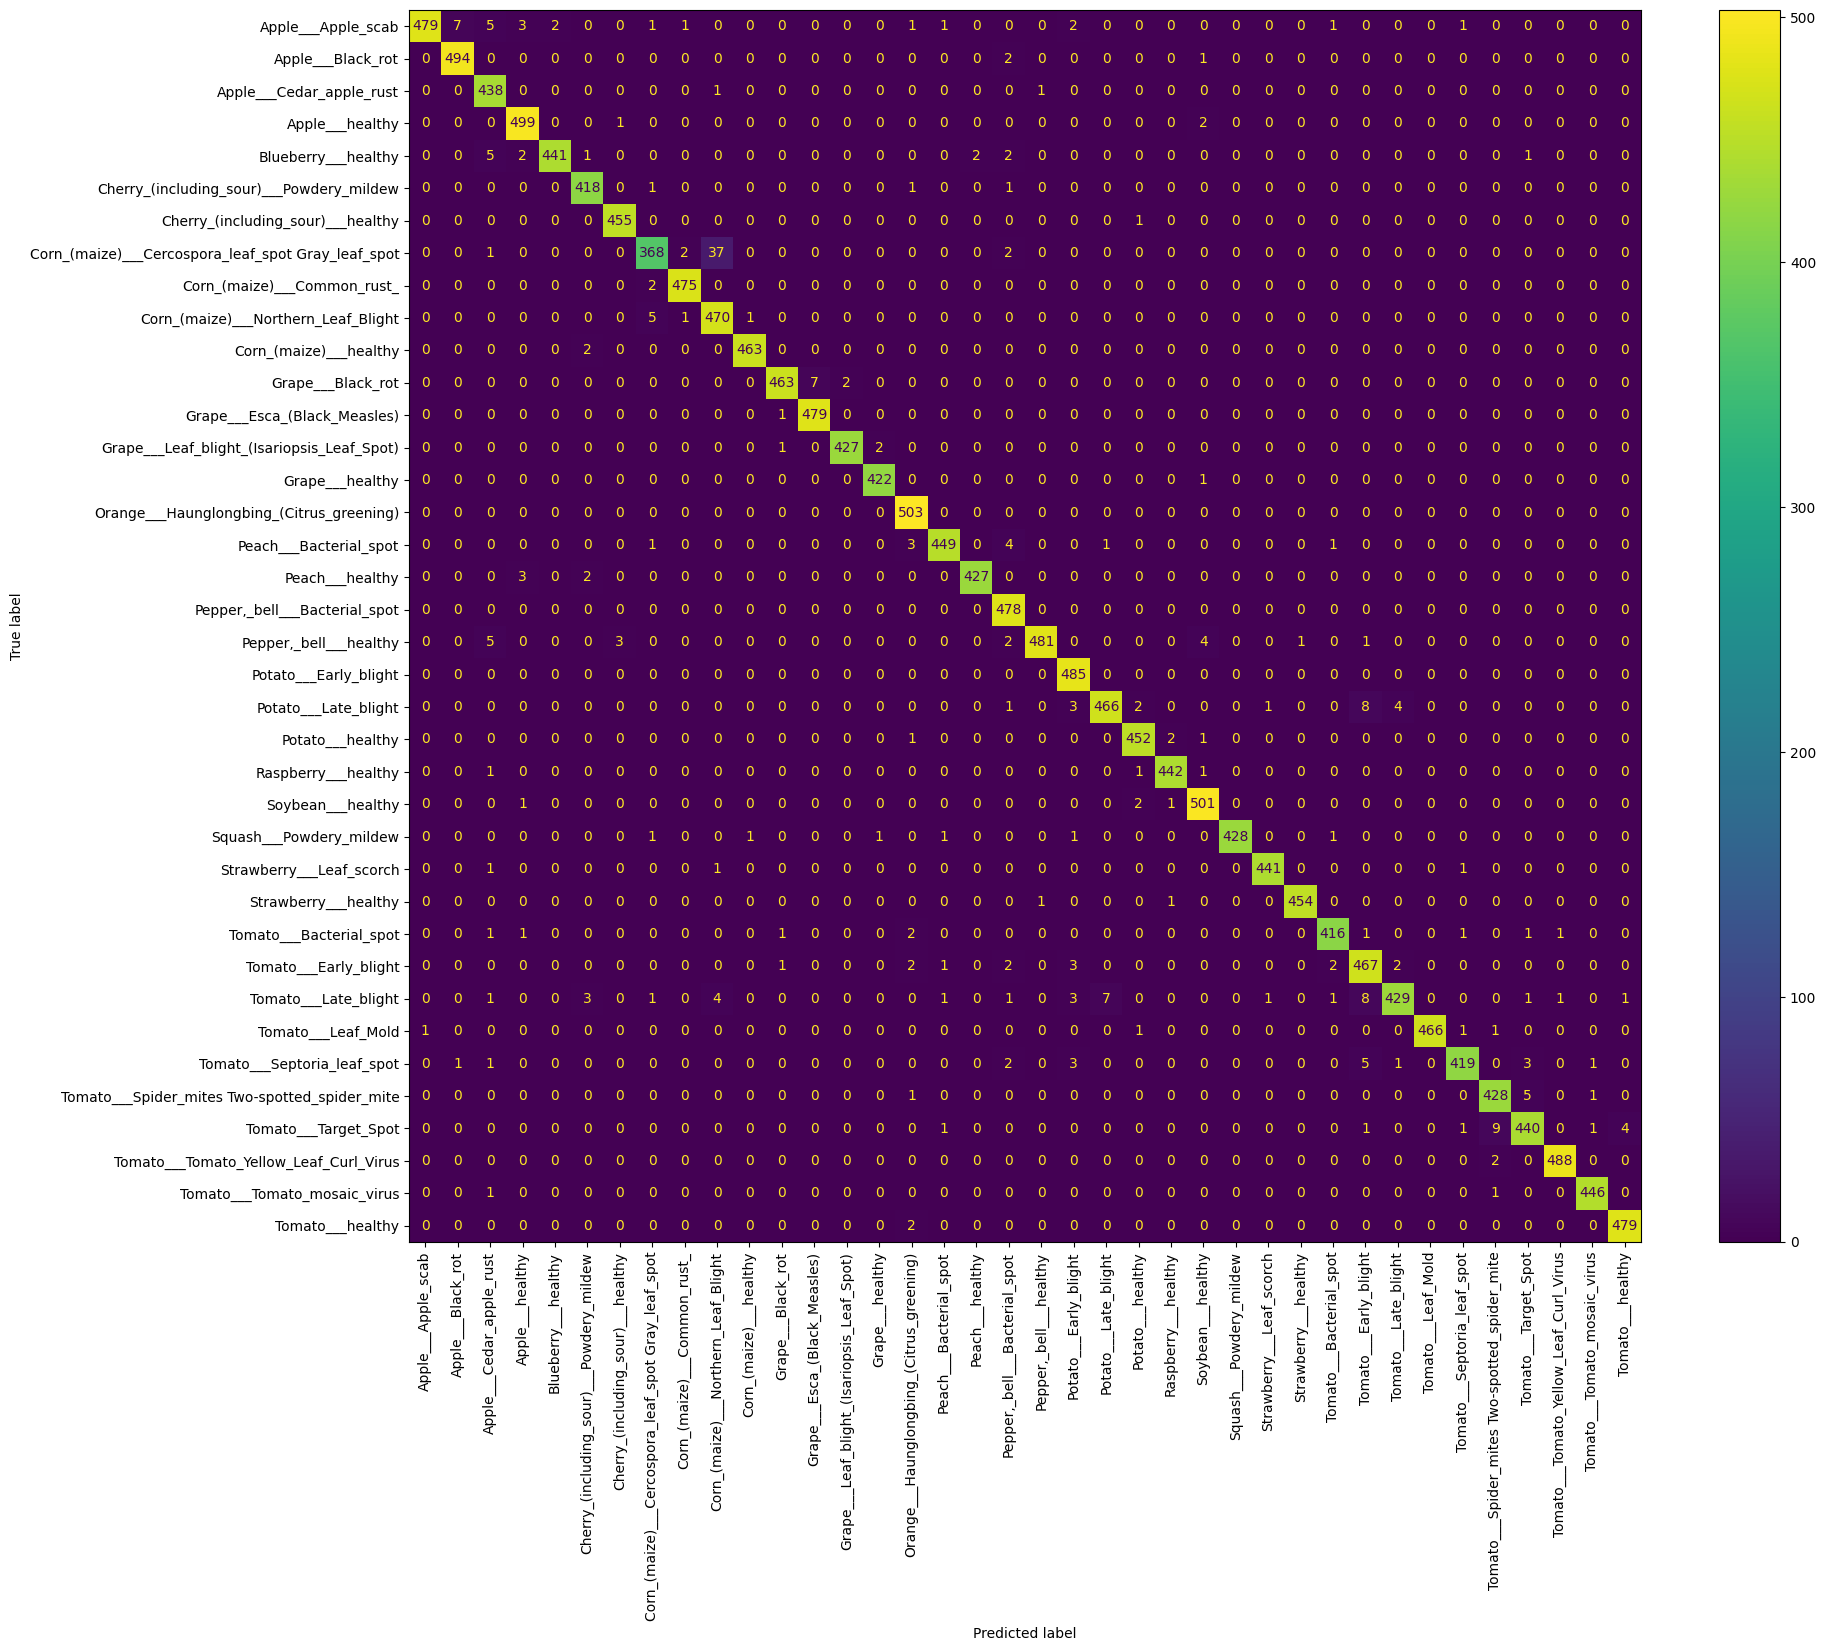

In [131]:
Display_Confusion_Matrix(val_true,val_pred,class_name_lookup) # confusion-matrix

In [12]:
def Dispay_Classifiation_Report(val_true,val_pred,class_name_lookup):
################################################################################
# classifiation report printing here
  display_labels = list(class_name_lookup.values())
  print(classification_report(val_true,val_pred,target_names=class_name_lookup.values()))
################################################################################

In [ ]:
Dispay_Classifiation_Report(val_true,val_pred,class_name_lookup)

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      0.86      0.92       504
                                 Apple___Black_rot       0.98      0.98      0.98       497
                          Apple___Cedar_apple_rust       0.98      0.98      0.98       440
                                   Apple___healthy       0.93      0.99      0.95       502
                               Blueberry___healthy       0.96      0.96      0.96       454
          Cherry_(including_sour)___Powdery_mildew       0.99      0.98      0.98       421
                 Cherry_(including_sour)___healthy       0.96      1.00      0.98       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.94      0.93      0.93       410
                       Corn_(maize)___Common_rust_       0.99      1.00      0.99       477
               Corn_(maize)___Northern_Leaf_Blight       0.96      0.94      0.

In [ ]:
target=validation_data.class_indices.keys() # getting the classs names for printing the ROC Graph
y_test =  validation_data.classes

In [15]:
################################################################################
# function  roc auc score for multi-class datasets, since this dataset has 38 class
# funtion calling 2 times
def Multiclass_Roc_Auc_Scores(y_test, y_pred,min_class,max_class, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    i=0
    for (idx, c_label) in enumerate(target):
          i=i+1
          fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
          if i>=min_class and i<=max_class:
            c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

ROC AUC score: 0.9779520662105483


Text(0, 0.5, 'True Positive Rate')

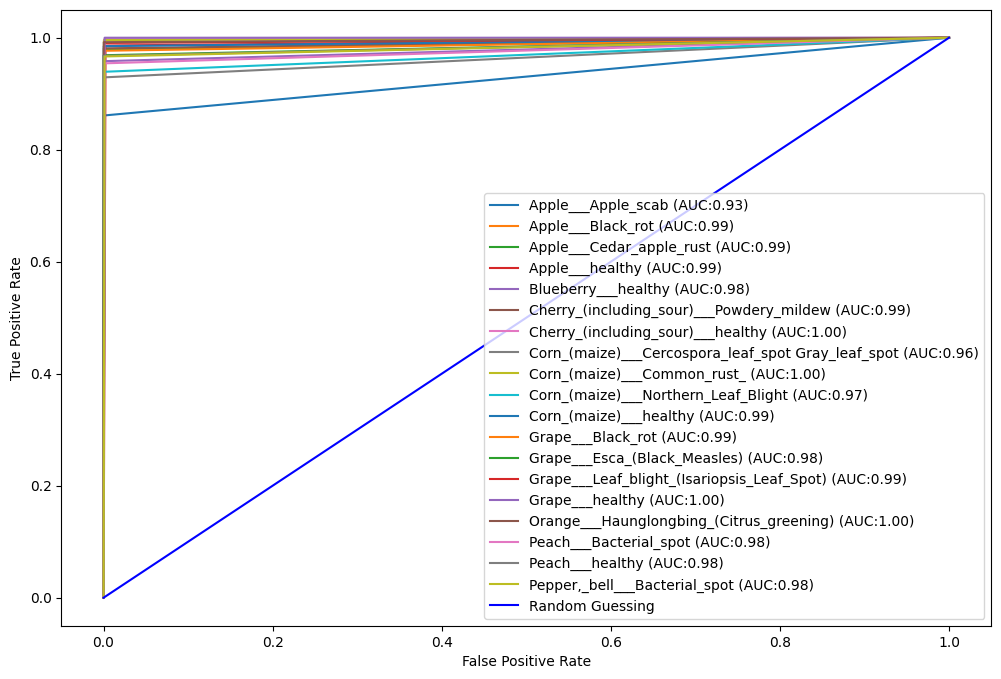

In [ ]:
################################################################################
#Printing ROC curve for the class 1-19 here
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
print('ROC AUC score:', Multiclass_Roc_Auc_Scores(y_test, val_pred,1,19))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')


In [147]:
#model.save('final_model.h5') # saving the Model here, so that re-use the model later
model.save('model_12epochs50batchsize.h5') # saving the Model here, so that re-use the model later

In [13]:
def model_evalution(ev_model,value_data,model_size):
    ################################################################################
    #Model evalution : # Getting  validation accuracy and model size time to train
    ################################################################################
    start = perf_counter()
    loss,Model_Accuracy = ev_model.evaluate(value_data, verbose = 0 )
    end = perf_counter()
    ModelSize = model_size
    # let convert to MB
    ModelSize = ModelSize / (1024 * 1024)
    #-------------------------------------------------------------------------------
    print('Model Summary:')
    print('Model size(MB)                : {}'.format(ModelSize))
    print('Time on Validation data (sec) : {}'.format(end - start))
    print('Accuracy on validation data   : {}'.format(Model_Accuracy))
    print('Loss on validation data       : {}'.format(loss))
    #print('Time on Training Model  (sec) : {}'.format(end_training - start_training)

In [140]:
model_evalution(model,validation_data,os.path.getsize('final_model.h5'))

Model Summary:
Model size(MB)                : 31.24981689453125
Time on Validation data (sec) : 30.297829258001002
Accuracy on validation data   : 0.9831550121307373
Loss on validation data       : 0.05319163203239441


# Testing using AI Challenger 2018 Plant Dataset from the Paper: #

** Transfer Learning by changing the dataset used --> need to change the output softmax size from 38 classes to 61classes **

Crop Disease Reognition Based on Modified Light-Weight CNN With Attention Mechanism

Dataset:
https://www.kaggle.com/code/kerneler/starter-ai-challenger-pdr2018-1e976fdd-5/input

Found Labels in 2 spots:
1. https://github.com/xungeer29/AI-Challenger-Plant-Disease-Recognition/tree/master --> This one is best has a great chart!
2. https://github.com/bochuanwu/Agricultural-Disease-Classification/tree/master

In [14]:
# dictionary: 'key':value
ai_challenger_2018_dataset_labels = {
    0: 'apple healthy', 1: 'Apple_Scab general', 2: 'Apple_Scab serious', 3: 'Apple Frogeye Spot', 4: 'Cedar Apple Rust general',
    5: 'Cedar Apple Rust serious', 6: 'Cherry healthy', 7: 'Cherry_Powdery Mildew general', 8: 'Cherry_Powdery Mildew serious',
    9: 'Corn healthy', 10: 'Cercospora zeaemaydis Tehon and Daniels general', 11: 'Cercospora zeaemaydis Tehon and Daniels serious',
    12: 'Puccinia polysora general', 13: 'Puccinia polysora serious', 14: 'Corn Curvularia leaf spot fungus general',
    15: 'Corn Curvularia leaf spot fungus serious', 16: 'Maize dwarf mosaic virus', 17: 'Grape heathy', 18: 'Grape Black Rot Fungus general',
    19: 'Grape Black Rot Fungus serious', 20: 'Grape Black Measles Fungus general', 21: 'Grape Black Measles Fungus serious',
    22: 'Grape Leaf Blight Fungus general', 23: 'Grape Leaf Blight Fungus serious', 24: 'Citrus healthy', 25: 'Citrus Greening June general',
    26: 'Citrus Greening June serious', 27: 'Peach healthy', 28: 'Peach_Bacterial Spot general', 29: 'Peach_Bacterial Spot serious',
    30: 'Pepper healthy', 31: 'Pepper scab general', 32: 'Pepper scab serious', 33: 'Potato healthy', 34: 'Potato_Early Blight Fungus general',
    35: 'Potato_Early Blight Fungus serious', 36: 'Potato_Late Blight Fungus general', 37: 'Potato_Late Blight Fungus serious',
    38: 'Strawberry healthy', 39: 'Strawberry_Scorch general', 40: 'Strawberry_Scorch serious', 41: 'Tomato healthy', 42: 'tomato powdery mildew general',
    43: 'tomato powdery mildew serious', 44: 'Tomato Bacterial Spot Bacteria general', 45: 'Tomato Bacterial Spot Bacteria serious',
    46: 'Tomato_Early Blight Fungus general', 47: 'Tomato_Early Blight Fungus serious', 48: 'Tomato_Late Blight Water Mold general',
    49: 'Tomato_Late Blight Water Mold serious', 50: 'Tomato_Leaf Mold Fungus general', 51: 'Tomato_Leaf Mold Fungus serious',
    52: 'Tomato Target Spot Bacteria general', 53: 'Tomato Target Spot Bacteria serious', 54: 'Tomato_Septoria Leaf Spot Fungus general',
    55: 'Tomato_Septoria Leaf Spot Fungus serious', 56: 'Tomato Spider Mite Damage general', 57: 'Tomato Spider Mite Damage serious',
    58: 'Tomato YLCV Virus general', 59: 'Tomato YLCV Virus serious', 60: 'Tomato Tomv',
}

In [15]:
# Upload your Kaggle API key (kaggle.json) obtained from your Kaggle account settings
from google.colab import files
files.upload()

# Move the API key to the correct location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle (1).json


In [16]:
# Download the specific file from the Kaggle dataset
!kaggle datasets download -d jinbao/ai-challenger-pdr2018 -f train.zip
!kaggle datasets download -d jinbao/ai-challenger-pdr2018 -f val.zip
!kaggle datasets download -d jinbao/ai-challenger-pdr2018 -f testA.zip

train.zip.zip: Skipping, found more recently modified local copy (use --force to force download)
val.zip.zip: Skipping, found more recently modified local copy (use --force to force download)
testA.zip.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# unzip download data
!unzip train.zip -d train_data_ai_challenger2018
!unzip val.zip -d validate_data_ai_challenger2018
!unzip testA.zip -d test_data_ai_challenger2018

Archive:  train.zip.zip
replace train_data_ai_challenger2018/train.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  val.zip.zip
replace validate_data_ai_challenger2018/val.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  testA.zip.zip
replace test_data_ai_challenger2018/testA.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# unzip download data - 2nd round
!unzip -q train_data_ai_challenger2018/train.zip -d train_data_ai_challenger2018
!unzip -q validate_data_ai_challenger2018/val.zip -d validate_data_ai_challenger2018
!unzip -q test_data_ai_challenger2018/testA.zip -d test_data_ai_challenger2018

In [ ]:
#Dataset locations for each of the 0-60 folders
train_path = "/content/train_data_ai_challenger2018/train"
validate_path = "/content/validate_data_ai_challenger2018/val"
test_path = "/content/test_data_ai_challenger2018/testA"
diseases   = os.listdir(train_path) # name of the folders here

# pre-allocate
list_classes = np.full(len(ai_challenger_2018_dataset_labels),"filler")

for i,disease in enumerate(diseases):
  list_classes[i] = ai_challenger_2018_dataset_labels[int(disease)]

print(len(list_classes))
print(list_classes)

## Transfer Learning Itself ##
(after loading data)
Setting the number of outputs on the traind model to be different and re-training as stated below.

Source: https://keras.io/guides/transfer_learning/

"A last, optional step, is fine-tuning, which consists of unfreezing the entire model you obtained above (or part of it), and re-training it on the new data with a very low learning rate. This can potentially achieve meaningful improvements, by incrementally adapting the pretrained features to the new data."

In [20]:
# Upload original model to be used for transfer learning
files.upload()

Saving model_12epochs50batchsize.h5 to model_12epochs50batchsize.h5


In [21]:
# Source for Loading Models: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
# upload save model to load
model = load_model('/content/model_12epochs50batchsize.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_1 (Bat  (None, 54, 54, 64)        256       
 chNormalization)                                                
                                                      

In [22]:
model.pop()  # Remove the last Dense layer

# Add a new Dense layer with output size 61 (adjust activation and other parameters as needed)
new_dense_layer = Dense(61, activation='softmax', name='dense_3_new')

# Add the new Dense layer to the model
model.add(new_dense_layer)

# Manually transfer weights from the old Dense layer to the new Dense layer
old_dense_weights = model.layers[-2].get_weights()  # Assuming the old Dense layer is the second-to-last layer
# Allow new dense weights to be initialized randomly, using:
# get_weights and set_weights will not work due to shape mismatch

# Compile the model (you may need to adjust the optimizer, loss, and metrics)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the modified model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_1 (Bat  (None, 54, 54, 64)        256       
 chNormalization)                                                
                                                      

In [23]:
################################################################################
#Model compiling
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
################################################################################
import keras.callbacks as callbacks
import time
early_stopping_cb = callbacks.EarlyStopping(monitor="loss", patience=3)

# Creaing Training and validation Datasets from paths and downloaded files #
To train the transfered model

In [24]:
#Setting the Traning dataset folder
training_set = ImageDataGenerator( rescale = 1/255.5)
training_data = training_set.flow_from_directory(
    train_path,
    target_size = (224,224),
    class_mode = "categorical",
    batch_size = batch_size
  )

Found 32739 images belonging to 61 classes.


In [25]:
  #Setting the validation dataset folder
validation_set = ImageDataGenerator( rescale = 1/255.5)
validation_data = validation_set.flow_from_directory(
    validate_path,
    target_size = (224,224),
    class_mode = "categorical",
    shuffle = False,  # For corretly printing the ConfusionMartix and Roc curvs
    batch_size = batch_size
)

Found 4982 images belonging to 61 classes.


In [26]:
#Finding the categories
categories = training_data.class_indices.keys()
print(categories)

dict_keys(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '7', '8', '9'])


# Train the Model on the new Data #

In [ ]:
# Load the model if training undesired for Transfer Learning Model that was trained on AI Challenger Dataset
files.upload()
# upload save model to load
model = load_model('/content/model_12epochs50batchsize.h5')
model.summary()
# skip next step if you load the model to avoid training

In [28]:
# Training the Transfer Model
start_training = perf_counter()
history = model.fit(
    training_data,
    validation_data = validation_data,
    epochs = 5, batch_size = 25,
    callbacks=[early_stopping_cb]
)
end_training= perf_counter()
elapsed_time = end_training - start_training

Epoch 1/5
1310/1310 [==============================] - 195s 149ms/step - loss: 0.6170 - accuracy: 0.7779 - val_loss: 0.5089 - val_accuracy: 0.7935
Epoch 2/5
1310/1310 [==============================] - 190s 145ms/step - loss: 0.4774 - accuracy: 0.8129 - val_loss: 0.4898 - val_accuracy: 0.7965
Epoch 3/5
1310/1310 [==============================] - 182s 139ms/step - loss: 0.4234 - accuracy: 0.8319 - val_loss: 0.4881 - val_accuracy: 0.8001
Epoch 4/5
1310/1310 [==============================] - 174s 133ms/step - loss: 0.3797 - accuracy: 0.8471 - val_loss: 0.4761 - val_accuracy: 0.8117
Epoch 5/5
1310/1310 [==============================] - 173s 132ms/step - loss: 0.3498 - accuracy: 0.8572 - val_loss: 0.5018 - val_accuracy: 0.7933


In [29]:
model.save('transferLearning_5epoch_25BatchSize.h5') # saving the Model here, so that re-use the model later

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
Display_Model_Loss_Accuracy(history) # calling funciton to print model accuracy graph

NameError: ignored

In [ ]:
number_test_images=12 # printing 12 images from the supplied test images
validate_test_images_and_display(model,number_test_images) # Prediting the supplied 33 images which is unkonw to the model

In [ ]:
#For confusion matrix
class_name_lookup = {name: index for index, name in training_data.class_indices.items()}
val_true = validation_data.classes
val_pred = np.argmax(model.predict(validation_data), axis = 1)
val_pred_float=model.predict(validation_data)
class_name_lookup = {name: index for index, name in training_data.class_indices.items()}

In [ ]:
Display_Confusion_Matrix(val_true,val_pred,class_name_lookup) # confusion-matrix

In [ ]:
model_evalution(model,validation_data,os.path.getsize('final_model.h5'))

In [ ]:
# find size and time to train model
model_evalution(model,validation_data,os.path.getsize('final_model.h5'))

In [ ]:
Dispay_Classifiation_Report(val_true,val_pred,class_name_lookup)

# View Same Filters on the Transfer Learning Model #
Same Maximization Activation as earlier, except for the transfer learning model applied to a different dataset

In [ ]:
# layer name      size    # tunable parameters
#  conv2d_11 (Conv2D)          (None, 3, 3, 512)         1180160
layer_name = 'conv2d_11' # Last of 6 convolution layers in our network
extract_intermediate_layer = ExtractIntermediateLayer(index_or_name=layer_name)
replace2linear = ReplaceToLinear()


# select the filters within the layer you would like to view
# for this example we will view
filter_numbers = [63, 132, 320]
scores = CategoricalScore(filter_numbers)

# Define seed inputs whose shape is (samples, height, width, channels).
# ActivationMaximization will maximize the value computed by the score function.
activation_maximization = ActivationMaximization(model,
                                                 # Please note that `extract_intermediate_layer` has to come before `replace2linear`.
                                                 model_modifier=[extract_intermediate_layer, replace2linear],
                                                 clone=False)

seed_input = tf.random.uniform((3, 224, 224, 3), 0, 255)

# Generate maximized activation
activations = activation_maximization(scores,
                                      seed_input=seed_input,
                                      callbacks=[Progress()])

In [ ]:
# Normalize activations
# handles cases where minimum activation is not zero
normalized_activations = [(act - np.min(act)) / (np.max(act) - np.min(act)) for act in activations]

## Since v0.6.0, calling `astype()` is NOT necessary.
# activations = activations[0].astype(np.uint8)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, filter_number in enumerate(filter_numbers):
    ax[i].set_title('filter[{:03d}]'.format(filter_number), fontsize=16)
    ax[i].imshow(normalized_activations[i], cmap='viridis')
    ax[i].axis('off')
plt.tight_layout()
plt.show()